# Measure Latency and Throughput for a LLM

This notebook demonstrates how to measure and analyze the performance of Large Language Models (LLMs) by examining key metrics like latency and throughput. You'll learn how different configuration settings affect model performance, including:

- **Generation length**: How the number of tokens to generate impacts speed
- **Numerical precision**: Comparing float16 vs float32 performance trade-offs  
- **KV caching**: The dramatic effect of key-value cache on inference speed

The experiments use PyTorch and Hugging Face Transformers with a lightweight model (TinyLlama) to ensure the notebook runs on various hardware configurations. Each section includes both practical code examples and explanations of the underlying concepts, making this a valuable resource for understanding LLM optimization in production environments.

**Key Learning Outcomes:**
- Measure latency, throughput, and tokens-per-second metrics
- Understand the relationship between generation length and computational cost
- Compare memory vs speed trade-offs with different precision settings
- Appreciate the critical importance of KV caching for efficient inference

## 0) Environment guard
Avoid NumPy 2.x + TensorFlow wheel conflicts by disabling optional TF/Flax imports in `transformers`.

### What is an Environment Guard?
When working with machine learning libraries, especially those that use native code (like TensorFlow, PyTorch, and NumPy), version conflicts can cause import errors or unexpected behavior. Here, we set environment variables to prevent the `transformers` library from trying to import TensorFlow or Flax, which avoids compatibility issues and ensures the notebook runs smoothly with PyTorch.

In [1]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

## 1) Imports & globals
If the preferred model isn't available, we fall back to a tiny model to keep the notebook runnable everywhere.

### Why Imports & Globals Matter
This section sets up the core libraries and global variables for the notebook. We use PyTorch and Hugging Face Transformers to load and run language models. The code ensures that the notebook can run on any machine by falling back to a small model if the preferred one is unavailable. This is important for reproducibility and accessibility.
- **PyTorch** is used for model execution and timing.
- **Transformers** provides easy access to pretrained LLMs.
- **Globals** like `device` and `PREFERRED_MODEL` make it easy to switch between CPU/GPU and different models.

In [2]:
import time
from typing import Dict, Any, List
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device={device}; NumPy={np.__version__}; Torch={torch.__version__}")

PREFERRED_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

DEFAULT_PROMPT = (
        "Artificial intelligence (AI) is intelligence demonstrated by machines, in contrast to the natural "
        "intelligence displayed by humans and animals. Leading AI textbooks define the field as the study "
        "of intelligent agents: any system that perceives its environment and takes actions that maximize "
        "its chance of achieving its goals. Colloquially, the term \"artificial intelligence\" is often "
        "used to describe machines that mimic cognitive functions that humans associate with the human mind, "
        "such as learning and problem-solving."
)


Device=cuda; NumPy=1.26.4; Torch=2.5.1


## 2) Helpers 

### Helper Functions for Metrics
This section defines utility functions to streamline model loading, generation, and metric calculation. These helpers make it easy to measure and compare different aspects of LLM performance, such as latency and throughput, under various settings. Understanding these metrics is crucial for evaluating and optimizing LLMs in production.

In [3]:
def _resolve_dtype(dtype_str: str, device: torch.device):
    if device.type == 'cpu' and dtype_str == 'float16':
        return torch.float32, 'float32 (forced on CPU)'
    return (torch.float16 if dtype_str == 'float16' else torch.float32), dtype_str

In [6]:
def load_model_and_tokenizer(model_name: str, dtype_str: str = 'float16'):
    """Load tokenizer/model with chosen precision; return (tokenizer, model, model_used, dtype_used_label)."""
    dtype, label = _resolve_dtype(dtype_str, device)
    for name in [model_name]:
        try:
            tok = AutoTokenizer.from_pretrained(name, use_fast=True)
            mdl = AutoModelForCausalLM.from_pretrained(name, torch_dtype=dtype)
            mdl.to(device)
            mdl.eval()
            if tok.pad_token_id is None and tok.eos_token_id is not None:
                tok.pad_token = tok.eos_token
            return tok, mdl, name, label
        except Exception:
            continue
    raise RuntimeError('Could not load any model from preferred/fallback list.')

In [5]:
def time_generate(model, tokenizer, prompt: str, max_new_tokens: int = 50, use_cache: bool = True,
                  num_warmup: int = 1, num_runs: int = 3) -> Dict[str, Any]:
    """Time model.generate and return metrics: total_latency_s, tokens_generated, tokens_per_sec, avg_latency_per_token_ms."""
    input_ids = tokenizer(prompt, return_tensors='pt').input_ids.to(model.device)
    with torch.no_grad():
        for _ in range(num_warmup):
            _ = model.generate(input_ids, max_new_tokens=8, use_cache=use_cache)
    latencies, tokens_out = [], []
    with torch.no_grad():
        for _ in range(num_runs):
            t0 = time.perf_counter()
            out = model.generate(input_ids, max_new_tokens=max_new_tokens, use_cache=use_cache)
            t1 = time.perf_counter()
            latencies.append(t1 - t0)
            tokens_out.append(out.shape[-1] - input_ids.shape[-1])
    L = sum(latencies) / max(len(latencies), 1)
    TG = sum(tokens_out) / max(len(tokens_out), 1)
    TPS = (TG / L) if L > 0 else float('nan')
    LPT = (L / max(TG, 1e-9)) * 1000.0
    return {'total_latency_s': L, 'tokens_generated': TG, 'tokens_per_sec': TPS, 'avg_latency_per_token_ms': LPT}

In [7]:
def plot_xy(xs: List[float], ys: List[float], xlabel: str, ylabel: str, title: str):
    plt.figure()
    plt.plot(xs, ys, marker='o')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

## 3) Baseline
Run one fixed setup as baseline: `max_new_tokens=50`, `float16`, `use_cache=True`.

### Baseline Measurement: Latency & Throughput
Before experimenting, it's important to establish a baseline. Here, we measure how long it takes the model to generate a fixed number of tokens (`max_new_tokens=50`) using default settings. The key metrics are:
- **Total Latency (s):** How long the generation takes.
- **Tokens Generated:** Number of tokens produced.
- **Tokens per Second (Throughput):** How fast the model generates tokens.
- **Average Latency per Token (ms):** Fine-grained latency per output token.
This baseline helps you compare the impact of different settings in later sections.

In [7]:
tokenizer, model, MODEL_USED, DTYPE_USED = load_model_and_tokenizer(PREFERRED_MODEL, dtype_str='float16')
print(f"Loaded: {MODEL_USED} | dtype={DTYPE_USED}")
baseline = time_generate(model, tokenizer, DEFAULT_PROMPT, max_new_tokens=50, use_cache=True)
assert all(k in baseline for k in ['total_latency_s','tokens_generated','tokens_per_sec','avg_latency_per_token_ms'])
baseline

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Loaded: TinyLlama/TinyLlama-1.1B-Chat-v1.0 | dtype=float16


{'total_latency_s': 1.3203678546666804,
 'tokens_generated': 50.0,
 'tokens_per_sec': 37.868234843253,
 'avg_latency_per_token_ms': 26.40735709333361}

## 4) Exercise A — Generation Length vs Cost
Vary `max_new_tokens` and plot latency/throughput.

### Exercise A: Generation Length vs. Cost
In this section, you will see how the number of tokens you ask the model to generate (`max_new_tokens`) affects both latency and throughput. Longer generations usually mean higher latency, but the relationship with throughput can reveal model efficiency. The code runs the model with different generation lengths and plots the results, helping you visualize the trade-offs.

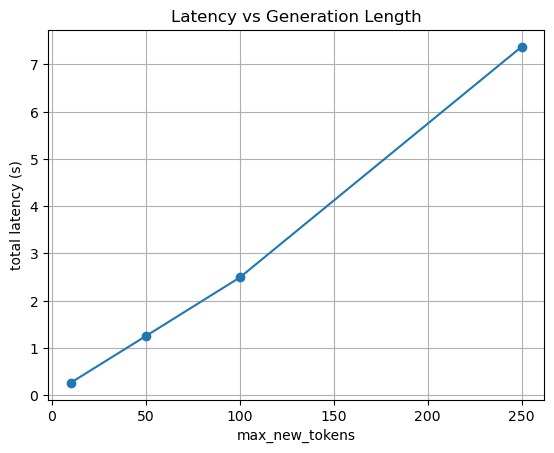

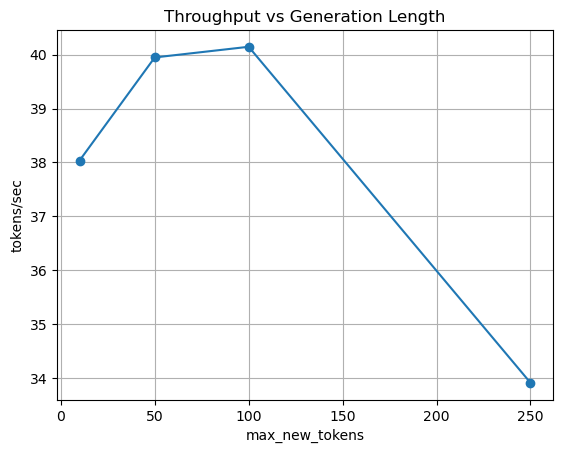

In [8]:
def run_for_varied_lengths():
    lengths = [10, 50, 100, 250]
    results_len = []
    for L in lengths:
        m = time_generate(model, tokenizer, DEFAULT_PROMPT, max_new_tokens=L, use_cache=True)
        results_len.append(m)
    latencies = [r['total_latency_s'] for r in results_len]
    throughputs = [r['tokens_per_sec'] for r in results_len]
    plot_xy(lengths, latencies, xlabel='max_new_tokens', ylabel='total latency (s)', title='Latency vs Generation Length')
    plot_xy(lengths, throughputs, xlabel='max_new_tokens', ylabel='tokens/sec', title='Throughput vs Generation Length')


run_for_varied_lengths()

## 5) Exercise B — Numerical Precision (float16 vs float32)
Reload for each precision with identical settings and compare.

### Exercise B: Numerical Precision (float16 vs float32)
Numerical precision affects both speed and memory usage. `float16` (half-precision) is faster and uses less memory, but may be less accurate or even unsupported on some hardware. `float32` (single-precision) is the default for most ML tasks. This section compares the two by running the same generation task with each precision and measuring the impact on latency and throughput.

In [9]:
def run_varied_precision(precisions=None):
    if precisions is None:
        precisions = ['float16', 'float32']

    compare_precision = {}
    for p in precisions:
        tok, mod, used, dlab = load_model_and_tokenizer(PREFERRED_MODEL, dtype_str=p)
        compare_precision[p] = time_generate(mod, tok, DEFAULT_PROMPT, max_new_tokens=50, use_cache=True)
    return compare_precision

In [9]:
compare_precision = run_varied_precision(['float16'])

for p, metrics in compare_precision.items():
    print(f"Precision: {p} | Metrics: {metrics}")

Precision: float16 | Metrics: {'total_latency_s': 1.3481758750000001, 'tokens_generated': 50.0, 'tokens_per_sec': 37.087149330572316, 'avg_latency_per_token_ms': 26.963517500000002}


In [10]:
compare_precision = run_varied_precision(['float32'])

for p, metrics in compare_precision.items():
    print(f"Precision: {p} | Metrics: {metrics}")

Precision: float32 | Metrics: {'total_latency_s': 1.4556118953334287, 'tokens_generated': 50.0, 'tokens_per_sec': 34.34981546956016, 'avg_latency_per_token_ms': 29.11223790666857}


## 6) Exercise C — KV Cache On vs Off
Use the same model and toggle `use_cache`.

### Exercise C: KV Cache On vs Off
The Key-Value (KV) cache is a feature in transformer models that stores intermediate results during generation, allowing for faster inference when generating long sequences. Disabling the cache can significantly slow down generation. This section compares performance with the cache enabled and disabled, illustrating the importance of caching for LLM efficiency.

In [7]:
kv_results = {}
kv_results['use_cache=True'] = time_generate(model, tokenizer, DEFAULT_PROMPT, max_new_tokens=50, use_cache=True)
kv_results['use_cache=False'] = time_generate(model, tokenizer, DEFAULT_PROMPT, max_new_tokens=50, use_cache=False)
kv_results

{'use_cache=True': {'total_latency_s': 0.997685762316299,
  'tokens_generated': 50.0,
  'tokens_per_sec': 50.115980290143064,
  'avg_latency_per_token_ms': 19.95371524632598},
 'use_cache=False': {'total_latency_s': 1.167668834348054,
  'tokens_generated': 50.0,
  'tokens_per_sec': 42.82036013054726,
  'avg_latency_per_token_ms': 23.353376686961077}}

## 7) Compact summary table
Summarize the three ideas in a small table.

### Summary Table: Comparing All Settings
This optional section summarizes the results from the previous experiments in a single table. Comparing the baseline, different precisions, and cache settings side-by-side helps you quickly see the trade-offs and make informed decisions about model deployment and optimization.

In [8]:
import pandas as pd
rows = []
rows.append({'label':'baseline (fp16, cache on)','dtype':'float16','use_cache':True,'max_new_tokens':50, **baseline})
rows.append({'label':'fp32, cache on','dtype':'float32','use_cache':True,'max_new_tokens':50, **compare_precision['float32']})
rows.append({'label':'fp16, cache off','dtype':'float16','use_cache':False,'max_new_tokens':50, **kv_results['use_cache=False']})
df = pd.DataFrame(rows)
df

,label,dtype,use_cache,max_new_tokens,total_latency_s,tokens_generated,tokens_per_sec,avg_latency_per_token_ms
0,"baseline (fp16, cache on)",float16,True,50,0.982037,50.0,50.914603,19.640730
1,"fp32, cache on",float32,True,50,1.129661,50.0,44.261063,22.593222
2,"fp16, cache off",float16,False,50,1.167669,50.0,42.820360,23.353377
